In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from pathlib import Path

In [141]:
df = pd.read_csv('Ratio.csv')

Ratio_Spectra = []
for i in df['Ratio']:
    input_string = i

    # Remove unwanted characters
    cleaned_string = input_string.replace("[", "").replace("]", "")

    # Split the string into components and convert to float
    number_list = [float(num) for num in cleaned_string.split() if num]
    Ratio_Spectra.append(number_list)
    
df['Ratio_Spectra'] = pd.Series(Ratio_Spectra)

In [142]:
df_spectra = pd.DataFrame(df['Ratio_Spectra'].values.tolist(), index=df.index)
df_spectra.columns = [str(i) for i in np.arange(1250,3000,2)]
df_spectra.shape

(35521, 875)

In [143]:
df_spectra = df_spectra.dropna()
df_spectra.shape

(35466, 875)

In [144]:
# Calculate PCA Reconstruction Error with 20 components
def Reconstruction_Error(dataset):
    df = dataset.iloc[:,4:855]
    pca = PCA(n_components=10)
    df_pca = pca.fit_transform(df)
    df_reconstruction = pca.inverse_transform(df_pca)
    errors = np.linalg.norm(df - df_reconstruction, axis=1) / np.sqrt(df.shape[1])
    return errors

df_spectra['Error'] = Reconstruction_Error(df_spectra)

In [145]:
df_spectra = df_spectra[df_spectra['Error'] < 0.5]
df_spectra.shape

(23529, 876)

In [146]:
df_spectra = df_spectra.sort_values(by='Error', ascending=True).drop(columns='Error').reset_index(drop=True)

In [147]:
df_spectra = df_spectra.head(10000).iloc[:,:-100]

In [150]:
def apply_pca_kmeans(df, n_components, n_clusters, kmeans_kwargs):
    pca = PCA(n_components=n_components)
    pca_df = pd.DataFrame(pca.fit_transform(df))
    kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
    model = kmeans.fit(pca_df)
    return model, pca_df

# Define KMeans kwargs
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

model_BAL, pca_BAL = apply_pca_kmeans(df_spectra, n_components=10, n_clusters=3, kmeans_kwargs=kmeans_kwargs)
model_No_BAL, pca_No_BAL = apply_pca_kmeans(df_spectra, n_components=10, n_clusters=3, kmeans_kwargs=kmeans_kwargs)

In [151]:
def Optimum_Cluster_Finder(dataset, kmeans_kwargs):
    """
    Find the optimum number of clusters using SSE and Silhouette coefficients.

    Parameters:
        dataset (pd.DataFrame): DataFrame containing the dataset.
        kmeans_kwargs (dict): Keyword arguments for KMeans.

    Returns:
        list: Silhouette coefficients for each cluster number.
        list: SSE for each cluster number.
    """
    silhouette_coefficients = []
    sse = []

    # Compute SSE and Silhouette coefficients for different cluster numbers
    with tqdm(total=10, desc="Computing SSE Scores") as pbar1, \
         tqdm(total=9, desc='Computing Silhouette Coefficients') as pbar2:
        for k in range(1, 11):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(dataset)
            sse.append(kmeans.inertia_)
            pbar1.update(1)
            if k > 1:
                score = silhouette_score(dataset, kmeans.labels_)
                silhouette_coefficients.append(score)
                pbar2.update(1)

    print("SSE Scores and Silhouette Coefficients Written")

    return silhouette_coefficients, sse

# Define KMeans kwargs
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# Find optimum clusters for BAL Dataset
silhouette_coefficients_BAL, sse_BAL = Optimum_Cluster_Finder(pca_BAL, kmeans_kwargs)

# Find optimum clusters for No BAL Dataset
silhouette_coefficients_No_BAL, sse_No_BAL = Optimum_Cluster_Finder(pca_No_BAL, kmeans_kwargs)

# Find elbow points using KneeLocator
kl_BAL = KneeLocator(range(1, 11), sse_BAL, curve='convex', direction='decreasing')
kl_No_BAL = KneeLocator(range(1, 11), sse_No_BAL, curve='convex', direction='decreasing')
print('The elbow for BAL Dataset is at the point: ', kl_BAL.elbow)
print('The elbow for No BAL Dataset is at the point: ', kl_No_BAL.elbow)

Computing SSE Scores: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


SSE Scores and Silhouette Coefficients Written


Computing SSE Scores: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

SSE Scores and Silhouette Coefficients Written
The elbow for BAL Dataset is at the point:  3
The elbow for No BAL Dataset is at the point:  3


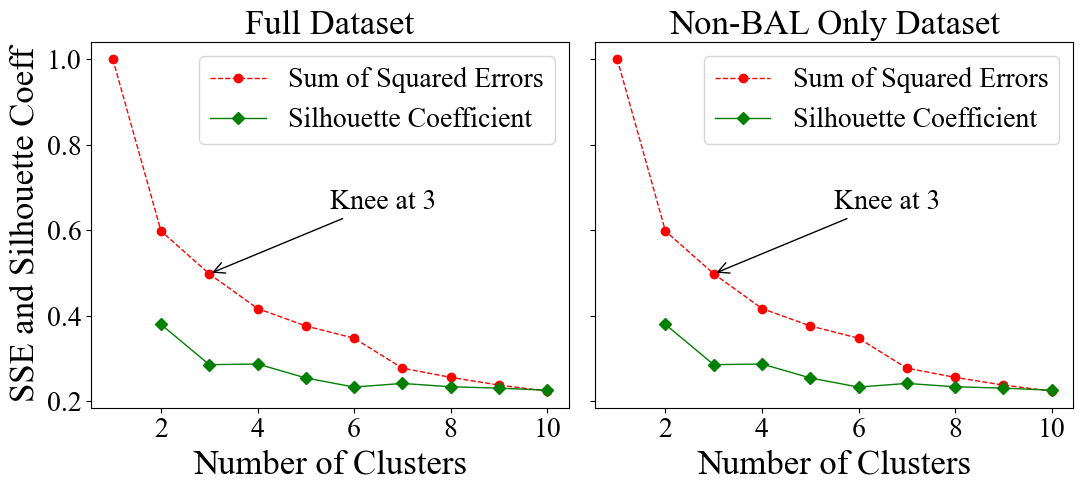

In [152]:
plt.style.use("default")
plt.rcParams['font.family'] = 'Times New Roman'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5),sharey=True,sharex=True)

ax1.plot(range(1, 11), [i/max(sse_BAL) for i in sse_BAL],'--', lw=1, marker='o', label='Sum of Squared Errors',c='red')
ax1.plot(range(2, 11), silhouette_coefficients_BAL, lw=1, marker='D', label='Silhouette Coefficient',c='green')

ax2.plot(range(1, 11), [i/max(sse_No_BAL) for i in sse_No_BAL],'--', lw=1, marker='o', label='Sum of Squared Errors',c='red')
ax2.plot(range(2, 11), silhouette_coefficients_No_BAL, lw=1, marker='D', label='Silhouette Coefficient',c='green')

ax1.set_xlabel("Number of Clusters", fontsize=25, fontname='Times New Roman')
ax1.set_ylabel("SSE and Silhouette Coeff", fontsize=25, fontname='Times New Roman')
ax2.set_xlabel("Number of Clusters", fontsize=25, fontname='Times New Roman')
#ax2.set_ylabel("SSE and Silhouette Coeff", fontsize=25, fontname='Times New Roman')

ax1.set_title("Full Dataset", fontsize=25, fontname='Times New Roman')
ax2.set_title("Non-BAL Only Dataset", fontsize=25, fontname='Times New Roman')

ax1.annotate(text=f'Knee at {kl_BAL.elbow}', xy=(kl_BAL.elbow, sse_BAL[2]/max(sse_BAL)), xytext=(5.5, 0.65),fontsize=20, arrowprops=dict(arrowstyle="->", connectionstyle='arc3'))
ax2.annotate(text=f'Knee at {kl_BAL.elbow}', xy=(kl_No_BAL.elbow, sse_No_BAL[2]/max(sse_No_BAL)), xytext=(5.5, 0.65),fontsize=20, arrowprops=dict(arrowstyle="->", connectionstyle='arc3'))

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

# Setting ticks for ax1
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1])

# Setting tick sizes
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()


plt.show()

In [153]:
kmeans_kwargs = {
        "init": "k-means++",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 1,
    }

model_BAL, pca_BAL = apply_pca_kmeans(df_spectra, n_components=10, n_clusters=3, kmeans_kwargs=kmeans_kwargs)

kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state":232
    }

model_No_BAL, pca_No_BAL = apply_pca_kmeans(df_spectra, n_components=10, n_clusters=3, kmeans_kwargs=kmeans_kwargs)

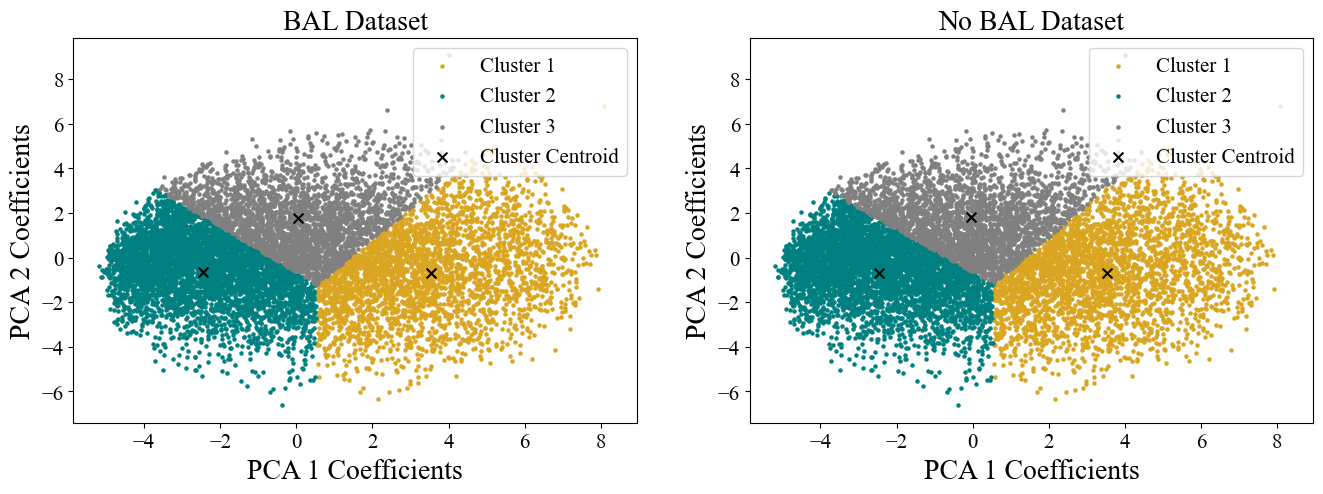

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

def plot_clusters(ax, pca_data, model_labels, cluster_centers, title):
    x = np.array(pca_data.iloc[:, 0])
    y = np.array(pca_data.iloc[:, 1])
    group = model_labels
    cdict = {2: 'gray', 0: 'goldenrod', 1: 'teal', 3: 'purple', 4: 'red'}
    if title=='No BAL Dataset':
        cdict = {2: 'gray', 0: 'goldenrod', 1: 'teal', 3: 'purple', 4: 'red'}
    
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(x[ix], y[ix], c=cdict[g], label=f'Cluster {g + 1}', s=5)
    
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=50, color='black', label='Cluster Centroid')
    ax.legend(fontsize=15)  # Set legend font size
    ax.tick_params(axis='both', which='major', labelsize=15)  # Set tick font size
    ax.set_xlabel('PCA 1 Coefficients', fontsize=20)  # Set x label font size
    ax.set_ylabel('PCA 2 Coefficients', fontsize=20)  # Set y label font size
    ax.set_title(title, fontsize=20)
    

def plot_clusters_combined(pca_BAL, model_BAL, pca_No_BAL, model_No_BAL):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    centroids_BAL = model_BAL.cluster_centers_
    centroids_No_BAL = model_No_BAL.cluster_centers_

    plot_clusters(ax1, pca_BAL, model_BAL.labels_, centroids_BAL, 'BAL Dataset')
    plot_clusters(ax2, pca_No_BAL, model_No_BAL.labels_, centroids_No_BAL, 'No BAL Dataset')
    
    plt.show()

# Assuming pca_BAL, model_BAL, pca_No_BAL, and model_No_BAL are already defined
plot_clusters_combined(pca_BAL, model_BAL, pca_No_BAL, model_No_BAL)

In [155]:
df_spectra['Cluster'] = model_BAL.labels_

In [156]:
df_spectra.value_counts('Cluster')

Cluster
1    4303
0    2964
2    2733
Name: count, dtype: int64

In [157]:
mean = df_spectra.groupby('Cluster').mean()

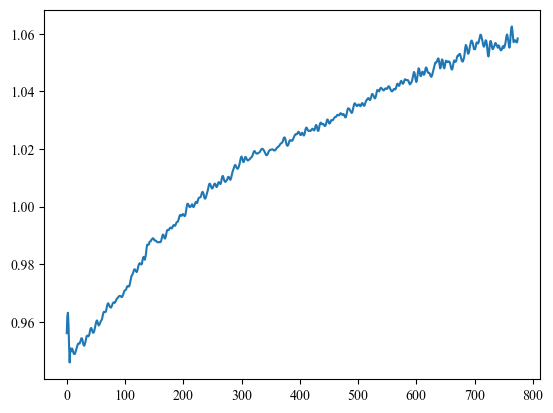

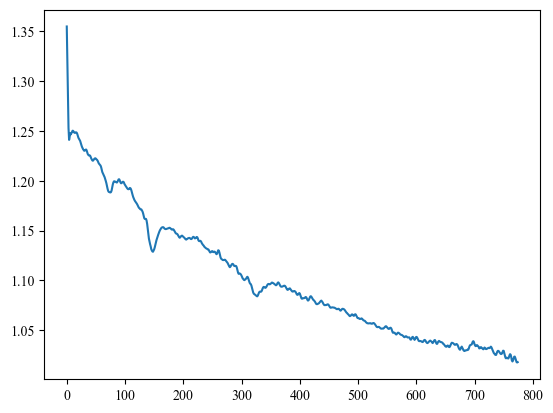

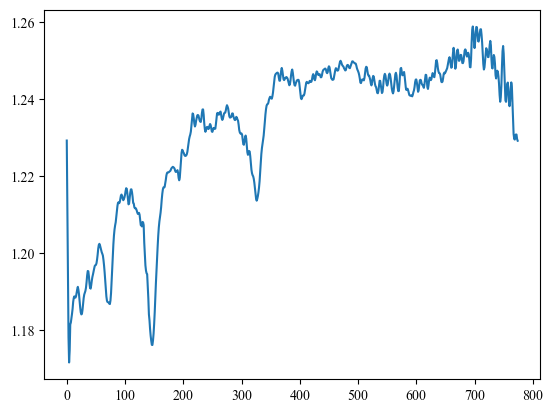

In [158]:
x = np.arange(0,mean.shape[1])
plt.plot(x,mean.iloc[1])
plt.show()
plt.plot(x,mean.iloc[2])
plt.show()
plt.plot(x,mean.iloc[0])